In [90]:
import pandas as pd
from pymongo import MongoClient
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
# import json
import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('ggplot')

from datetime import datetime
import boto3
import os
import time
import subprocess

In [42]:
from data.get_data import get_download_links

links_df = get_download_links()
links_df.head(20)

,month,link,downloaded,size_in_bytes,comment_count
0,2005-12,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
1,2006-01,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
2,2006-02,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
3,2006-03,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
4,2006-04,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
5,2006-05,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
6,2006-06,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
7,2006-07,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
8,2006-08,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
9,2006-09,https://files.pushshift.io/reddit/comments/RC_...,False,0,0


In [33]:
def calculate_polarity(month):
    """Calculate the polarity of each comment within a month. Update mongodb 
    collection with this data point."""

    sia = SIA()
    
    client = MongoClient()
    db = client['myreddit']
    collection_name = 'comments-' + month
    collection = db[collection_name]
    
    cursor = collection.find({'$and': 
                                   [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                    {'$expr': {'$gt': ['$score', 0]}}]
                           })

    for doc in cursor:
        _id = doc['_id']
        sentiment = sia.polarity_scores(doc['body'])['compound']
        collection.update_one({"_id": _id}, {"$set": {"vader_sentiment": sentiment}})
    
    client.close()

In [123]:
def monthly_statistics(month, subreddit=None):
    """Returns the average absolute sentiment polarity of a comment within a given month."""

    client = MongoClient()
    db = client['myreddit']
    collection_name = 'comments-' + month
    collection = db[collection_name]
    
    if subreddit == None:
        cursor = collection.find({'$and': 
                                       [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                        {'$expr': {'$gt': ['$score', 0]}}]
                                })
    else:
        cursor = collection.find({'$and': 
                                       [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                        {'$expr': {'$gt': ['$score', 0]}},
                                        {'subreddit': subreddit}]
                                })
    
    comment_count = collection.estimated_document_count()
    
    total_n_words = 0
    total_abs_polarity = 0
    total_score = 0
    comment_count = 0
    for doc in cursor:
        try:
            total_n_words += len(doc['body'].split())
        except:
            pass
        total_abs_polarity += doc['score']*abs(doc['vader_sentiment'])
        total_score += doc['score']
        comment_count += 1

    try:
        avg_abs_polarity = total_abs_polarity/total_score
    except ZeroDivisionError:
        avg_abs_polarity = None
    
    try:
        avg_comment_count = total_n_words/comment_count
    except ZeroDivisionError:
        avg_comment_count = None
    
    client.close()
    
    return avg_abs_polarity, comment_count, avg_comment_count

In [ ]:
for idx, row in links_df.loc[120:144].iterrows():
    month = row['month']

    print('{}:\t{}'.format(idx,month), end='   ')
    start = time.time()
    calculate_polarity(month)
    print('Done in {:1.1f} seconds'.format(time.time() - start))
    
pprint.pprint(d)

120:	2015-12   Done in 116.0 seconds
121:	2016-01   Done in 149.5 seconds
122:	2016-02   Done in 249.1 seconds
123:	2016-03   Done in 395.7 seconds
124:	2016-04   Done in 320.4 seconds
125:	2016-05   Done in 301.8 seconds
126:	2016-06   Done in 333.2 seconds
127:	2016-07   Done in 438.6 seconds
128:	2016-08   Done in 358.1 seconds
129:	2016-09   Done in 483.8 seconds
130:	2016-10   Done in 756.2 seconds
131:	2016-11   Done in 896.3 seconds
132:	2016-12   Done in 549.8 seconds
133:	2017-01   

In [109]:
def get_sentiment(m_start, m_end, df, subreddit=None):

    d = {}
    for idx, row in df.loc[m_start:m_end].iterrows():
        month = row['month']
        if idx % 10 == 0:
            print(idx, month)
        aap, comment_count, avg_wordcount = monthly_statistics(month, subreddit=subreddit)
        d[month] = {'avg_abs_pol': aap, 'comment_count': comment_count, 'avg_wordcount': avg_wordcount}

    return d

In [ ]:
politics_data = get_sentiment(20, 140, links_df, subreddit='politics')

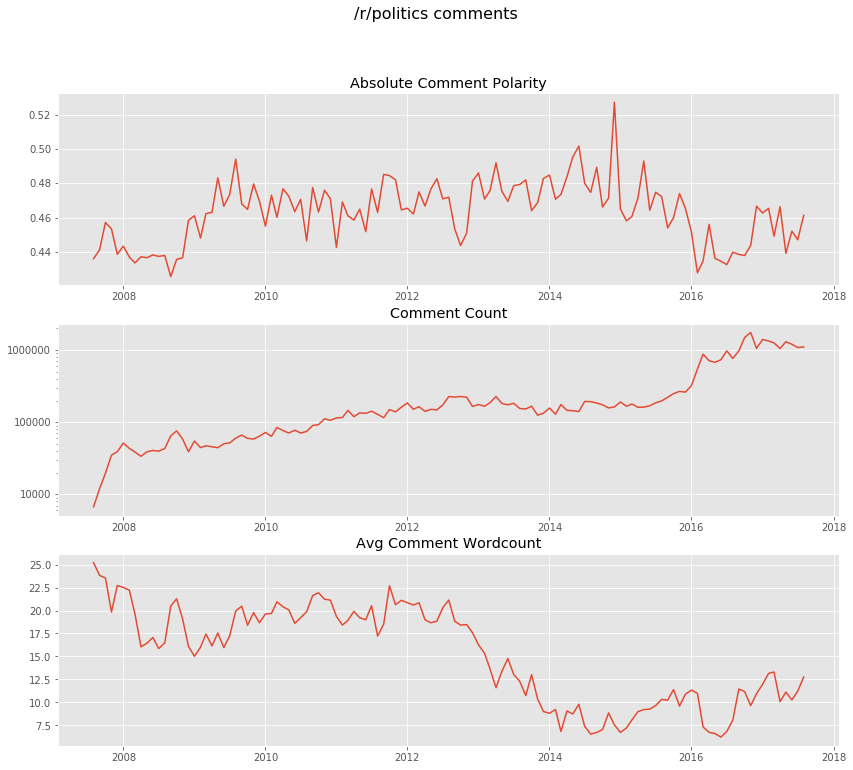

In [106]:
fig, axes = plt.subplots(3, 1, figsize=(14,12))
fig.suptitle('/r/politics comments', fontsize=16)

dates = [datetime.strptime(k, '%Y-%m') for k, _ in sorted(politics_data.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(politics_data.items())]
ccnt = [v['comment_count'] for _, v in sorted(politics_data.items())]
awc = [v['avg_wordcount'] for _, v in sorted(politics_data.items())]

axes[0].plot(dates, aap)
axes[0].set_title('Absolute Comment Polarity')
axes[1].plot(dates, ccnt)
axes[1].set_title('Comment Count')
axes[2].plot(dates, awc)
axes[2].set_title('Avg Comment Wordcount')

axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(ScalarFormatter())

In [ ]:
worldnews_data = get_sentiment(20, 140, links_df, subreddit='worldnews')

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02


[('2007-08',
  {'avg_abs_pol': None, 'avg_wordcount': 0.0, 'comment_count': 6711}),
 ('2007-09',
  {'avg_abs_pol': None, 'avg_wordcount': 0.0, 'comment_count': 11987}),
 ('2007-10',
  {'avg_abs_pol': None, 'avg_wordcount': 0.0, 'comment_count': 19588}),
 ('2007-11',
  {'avg_abs_pol': None, 'avg_wordcount': 0.0, 'comment_count': 34909}),
 ('2007-12',
  {'avg_abs_pol': None, 'avg_wordcount': 0.0, 'comment_count': 38973}),
 ('2008-01',
  {'avg_abs_pol': 0.42352,
   'avg_wordcount': 0.004334979199875588,
   'comment_count': 51442}),
 ('2008-02',
  {'avg_abs_pol': 0.36211188340807177,
   'avg_wordcount': 0.4089370033398595,
   'comment_count': 43415}),
 ('2008-03',
  {'avg_abs_pol': 0.4631927450566456,
   'avg_wordcount': 2.666632081344677,
   'comment_count': 38552}),
 ('2008-04',
  {'avg_abs_pol': 0.43566778302993975,
   'avg_wordcount': 5.8154157009567955,
   'comment_count': 33654}),
 ('2008-05',
  {'avg_abs_pol': 0.4499159831697069,
   'avg_wordcount': 5.6408222142084385,
   'comment_c

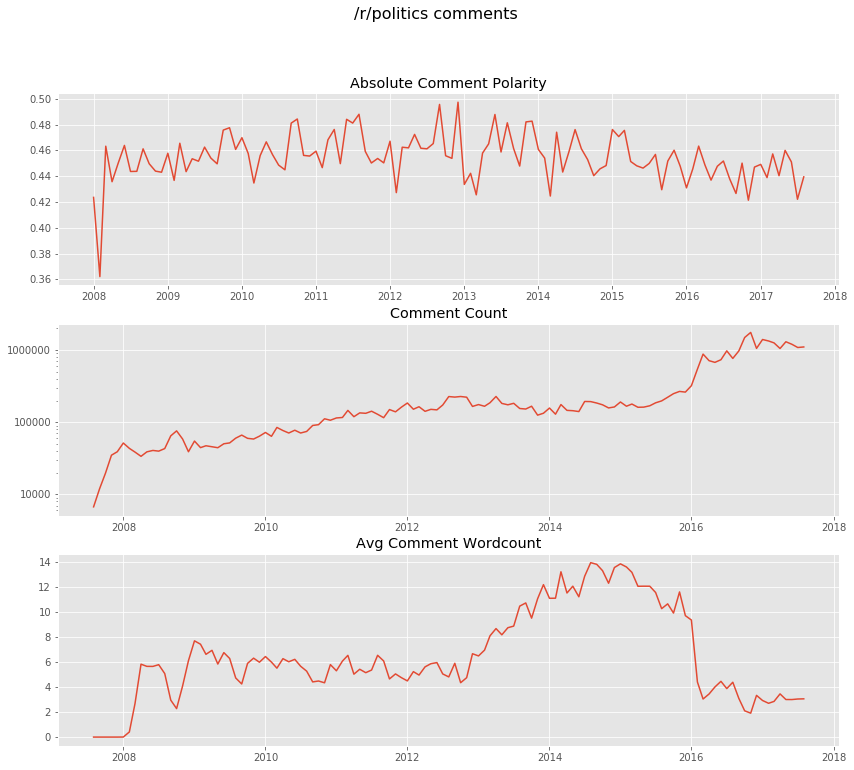

In [118]:
fig, axes = plt.subplots(3, 1, figsize=(14,12))
fig.suptitle('/r/politics comments', fontsize=16)

dates = [datetime.strptime(k, '%Y-%m') for k, _ in sorted(politics_data.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(worldnews_data.items())]
ccnt = [v['comment_count'] for _, v in sorted(worldnews_data.items())]
awc = [v['avg_wordcount'] for _, v in sorted(worldnews_data.items())]

axes[0].plot(dates, aap)
axes[0].set_title('Absolute Comment Polarity')
axes[1].plot(dates, ccnt)
axes[1].set_title('Comment Count')
axes[2].plot(dates, awc)
axes[2].set_title('Avg Comment Wordcount')

axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(ScalarFormatter())

pprint.pprint(sorted(worldnews_data.items()))